For the RFP control circuit:

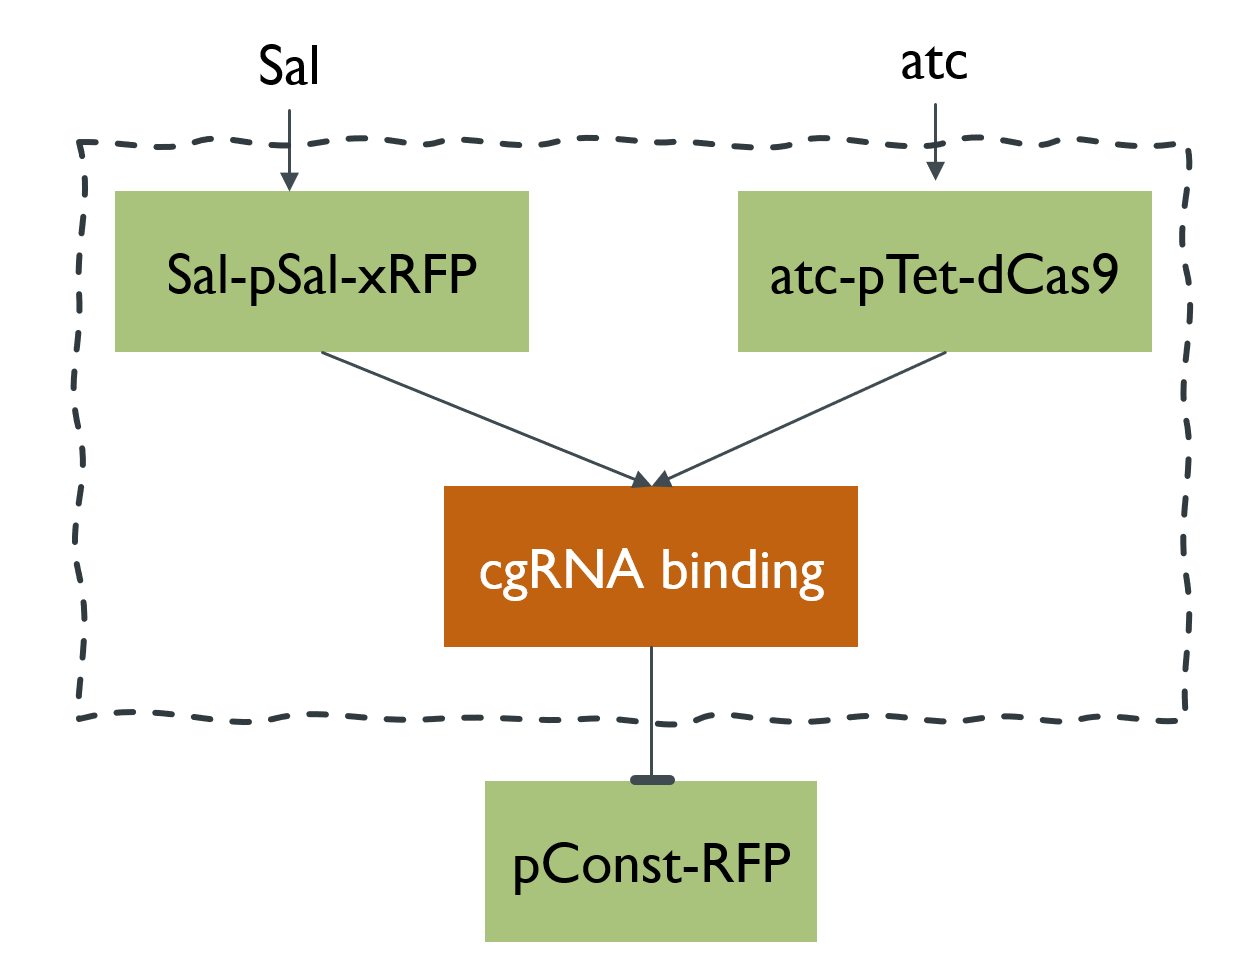

Subsystem 1: atc -> pSal -> xRFP gRNA

Subsystem 2: pConst -> RFP |- xRFP & dCas9

Subsystem 3: atc -| TetR -| pTet -> dCas9

Characterized parts availale: 
1. atc -| TetR -| pTet
2. pConst -> RFP
3. Sal -> pSal

In [1]:
import pandas as pd
from io import StringIO
# Read the data from a string
data = '''
Inducer,Plasmid,Regulator,Promoter,ymax (RPU),ymin (RPUx10-3),K (µM),n,Dynamic range
DAPG,pAJM.847,PhlFAM,PPhlF,2.50,2.5,1.700,2.1,1000
Cuma,pAJM.657,CymRAM,PCymRC,3.70,4.3,8.900,2.4,870
OC6,pAJM.474,LuxR,PLuxB,1.30,2.4,0.120,1.8,540
Van,pAJM.773,VanRAM,PVanCC,3.00,2.4,26.000,2.3,1200
IPTG,pAJM.336,LacIAM,PTac,3.30,4.8,140.000,1.8,690
aTc,pAJM.011,TetR,PTet*,2.40,4.9,0.013,3.8,500
Ara,pAJM.677,AraCAM,PBAD,1.20,2.4,37.000,1.5,500
Cho,pAJM.683,BetIAM,PBetI,2.60,8.5,4100.00,2.7,310
Nar,pAJM.661,TtgRAM,PTtg,0.46,3.4,95.000,1.9,140
DHBA,pAJM.690,PcaUAM,P3B5B,1.60,4.5,370.000,1.8,360
Sal,pAJM.771,NahRAM,PSalTTC,2.80,4.7,43.000,1.8,600
OHC14,pAJM.1642,CinRAM,PCin,1.50,3.0,0.430,2.3,490
Acr,pAJM.884,AcuRAM,PAcu,3.10,37.0,130.000,2.5,83
Ery,pAJM.969,MphRAM,PMph,0.29,8.0,65.000,1.5,36
'''
df = pd.read_csv(StringIO(data))



In [2]:
df

,Inducer,Plasmid,Regulator,Promoter,ymax (RPU),ymin (RPUx10-3),K (µM),n,Dynamic range
0,DAPG,pAJM.847,PhlFAM,PPhlF,2.50,2.5,1.700,2.1,1000
1,Cuma,pAJM.657,CymRAM,PCymRC,3.70,4.3,8.900,2.4,870
2,OC6,pAJM.474,LuxR,PLuxB,1.30,2.4,0.120,1.8,540
3,Van,pAJM.773,VanRAM,PVanCC,3.00,2.4,26.000,2.3,1200
4,IPTG,pAJM.336,LacIAM,PTac,3.30,4.8,140.000,1.8,690
5,aTc,pAJM.011,TetR,PTet*,2.40,4.9,0.013,3.8,500
6,Ara,pAJM.677,AraCAM,PBAD,1.20,2.4,37.000,1.5,500
7,Cho,pAJM.683,BetIAM,PBetI,2.60,8.5,4100.000,2.7,310
8,Nar,pAJM.661,TtgRAM,PTtg,0.46,3.4,95.000,1.9,140
9,DHBA,pAJM.690,PcaUAM,P3B5B,1.60,4.5,370.000,1.8,360


### Contracts for Sal sensor


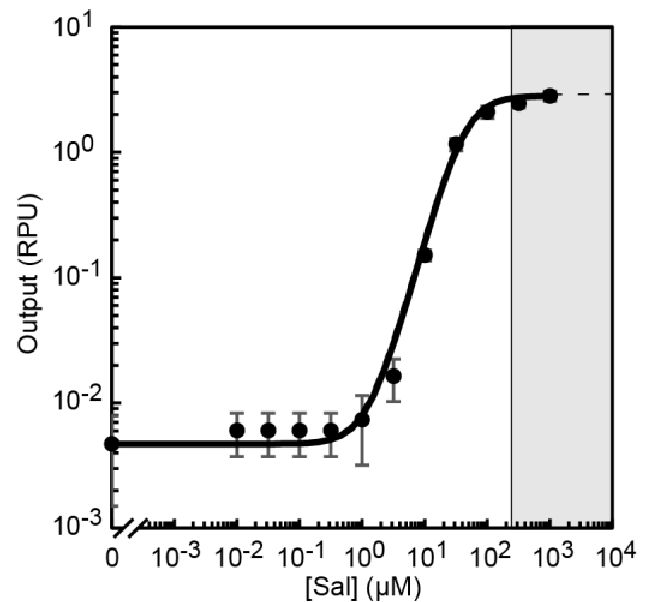

In [3]:
yleak_sal = df.loc[df["Inducer"] == "Sal"]["ymin (RPUx10-3)"].values[0]*1e-3
sal_start = 0.9
sal_K = df.loc[df["Inducer"] == "Sal"]["K (µM)"].values[0]
ymax_sal = 1.3
sal_slope = (ymax_sal - yleak_sal)/(sal_K - sal_start)
sal_intercept = yleak_sal - sal_slope*sal_start
sal_output = "xRFP"
contract_sal0 = {
        "_comment": "",
        "InputVars":[
            "sal"
        ],
        "OutputVars":[
            sal_output
        ],
        "assumptions":
        [
            {"coefficients":{"sal":1},
            "constant":sal_start}
        ],
        "guarantees":[
            {"coefficients":{sal_output:-1},
            "constant":-yleak_sal},
            {"coefficients":{sal_output:1},
            "constant":yleak_sal}
        ]
    }
contract_sal_lin = {
        "_comment": "",
        "InputVars":[
            "sal"
        ],
        "OutputVars":[
            sal_output
        ],
        "assumptions":
        [
            {"coefficients":{"sal":1},
            "constant":sal_K},
            {"coefficients":{"sal":-1},
            "constant":-sal_start}
        ],
        "guarantees":[
            {"coefficients":{sal_output:-1, "sal":sal_slope},
            "constant":sal_intercept}, # make sure that there is wiggle room?
            {"coefficients":{sal_output:1, "sal":-sal_slope},
            "constant":-sal_intercept}
        ]
    }
contract_sal_max = {
        "_comment": "",
        "InputVars":[
            "sal"
        ],
        "OutputVars":[
            sal_output
        ],
        "assumptions":
        [
            {"coefficients":{"sal":-1},
            "constant":-sal_K}
        ],
        "guarantees":[
            {"coefficients":{sal_output:1},
            "constant":ymax_sal}
        ]
    }

### Contracts for aTc sensor

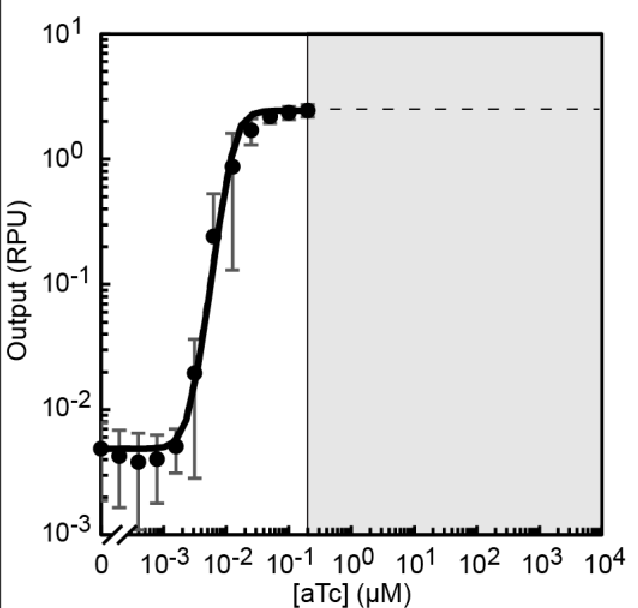

In [4]:
yleak_atc = df.loc[df["Inducer"] == "aTc"]["ymin (RPUx10-3)"].values[0]*1e-3
atc_start = 1.8*10**-3
atc_K = df.loc[df["Inducer"] == "aTc"]["K (µM)"].values[0]
ymax_atc =1
atc_slope = (ymax_atc - yleak_atc)/(atc_K - atc_start)
atc_intercept = yleak_atc - atc_slope*atc_start
atc_output = "dCas9"
contract_atc0 = {
        "_comment": "",
        "InputVars":[
            "atc"
        ],
        "OutputVars":[
            atc_output
        ],
        "assumptions":
        [
            {"coefficients":{"atc":1},
            "constant":atc_start}
        ],
        "guarantees":[
            {"coefficients":{atc_output:-1},
            "constant":-yleak_atc},
            {"coefficients":{atc_output:1},
            "constant":yleak_atc}
        ]
    }
contract_atc_lin = {
        "_comment": "",
        "InputVars":[
            "atc"
        ],
        "OutputVars":[
            atc_output
        ],
        "assumptions":
        [
            {"coefficients":{"atc":1},
            "constant":atc_K},
            {"coefficients":{"atc":-1},
            "constant":-atc_start}
        ],
        "guarantees":[
            {"coefficients":{atc_output:-1, "atc":atc_slope},
            "constant":atc_intercept}, # make sure that there is wiggle room?
            {"coefficients":{atc_output:1, "atc":-atc_slope},
            "constant":-atc_intercept}
        ]
    }
contract_atc_max = {
        "_comment": "",
        "InputVars":[
            "atc"
        ],
        "OutputVars":[
            atc_output
        ],
        "assumptions":
        [
            {"coefficients":{"atc":-1},
            "constant":-atc_K}
        ],
        "guarantees":[
            {"coefficients":{atc_output:1},
            "constant":ymax_atc}
        ]
    }

### Top-level system contract

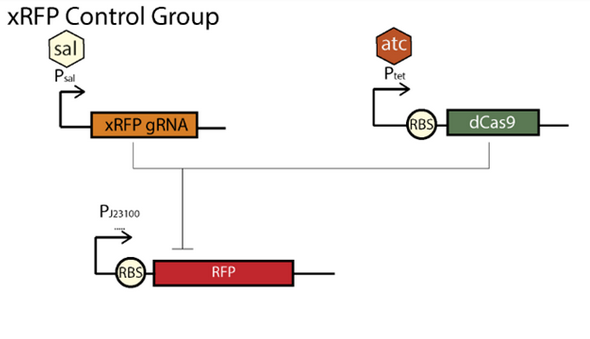

In [30]:
import numpy as np
leak_RFP = np.max([yleak_atc, yleak_sal])
max_RFP = np.max([ymax_atc, ymax_sal])
contract_top_level_on1 = {
        "_comment": "sal:OFF, atc:OFF, rfp:ON",
        "InputVars":[
            "sal", "atc"
        ],
        "OutputVars":[
            "RFP"
        ],
        "assumptions":
        [
            {"coefficients":{"sal":1},
            "constant":sal_start},
            {"coefficients":{"atc":1},
            "constant":atc_start}
        ],
        "guarantees":[
            {"coefficients":{"RFP":-1},
            "constant":-max_RFP},
        ]
    }
contract_top_level_on2 = {
        "_comment": "sal:ON, atc:OFF, rfp:ON",
        "InputVars":[
            "sal", "atc"
        ],
        "OutputVars":[
            "RFP"
        ],
        "assumptions":
        [
            {"coefficients":{"sal":-1},
            "constant":-sal_start},
            {"coefficients":{"atc":1},
            "constant":atc_start}
        ],
        "guarantees":[
            {"coefficients":{"RFP":-1},
            "constant":-max_RFP},
        ]
    }
contract_top_level_on3 = {
        "_comment": "sal:OFF, atc:ON, rfp:ON",
        "InputVars":[
            "sal", "atc"
        ],
        "OutputVars":[
            "RFP"
        ],
        "assumptions":
        [
            {"coefficients":{"sal":1},
            "constant":sal_start},
            {"coefficients":{"atc":-1},
            "constant":-atc_start}
        ],
        "guarantees":[
            {"coefficients":{"RFP":-1},
            "constant":-max_RFP},
        ]
    }
contract_top_level_off = {
        "_comment": "sal:ON, atc:ON, rfp:OFF",
        "InputVars":[
            "sal", "atc"
        ],
        "OutputVars":[
            "RFP"
        ],
        "assumptions":
        [
            {"coefficients":{"sal":-1},
            "constant":-sal_start},
            # {"coefficients":{"sal":1},
            # "constant":sal_K},
            {"coefficients":{"atc":-1},
            "constant":-atc_start},
            #   {"coefficients":{"atc":1},
            # "constant":atc_K},
        ],
        "guarantees":[
            # {"coefficients":{"RFP":-1, "sal":2, "atc":2},
            # "constant":-10},
            {"coefficients":{"RFP":1},
            "constant":leak_RFP},   
        ]
    }

In [31]:
from gear.terms.polyhedra.loaders import readContract, writeContract
csal0, csal1, csal2 = readContract([contract_sal0, contract_sal_lin, contract_sal_max])
catc0, catc1, catc2 = readContract([contract_atc0, contract_atc_lin, contract_atc_max])
ctop0, ctop1, ctop2, ctop3 = readContract([contract_top_level_on1, contract_top_level_on2, contract_top_level_on3, contract_top_level_off])

In [32]:
print(catc1)

InVars: [<Var atc>]
OutVars:[<Var dCas9>]
A: 1*atc <= 0.013, -1*atc <= -0.0018000000000000002
G: 88.84821428571429*atc + -1.0*dCas9 <= -0.15502678571428574, -88.84821428571429*atc + 1.0*dCas9 <= 0.15502678571428574


In [33]:
print(csal1)

InVars: [<Var sal>]
OutVars:[<Var xRFP>]
A: 1*sal <= 43.0, -1*sal <= -0.9
G: 0.03076722090261283*sal + -1.0*xRFP <= -0.0229904988123516, -0.03076722090261283*sal + 1.0*xRFP <= 0.02299049881235149


In [34]:
print(csal1.compose(catc1))

InVars: [<Var sal>, <Var atc>]
OutVars:[<Var xRFP>, <Var dCas9>]
A: 1*sal <= 43.0, -1*sal <= -0.9, 1*atc <= 0.0129999999999999, -1*atc <= -0.0018000000000000238
G: 0.03076722090261283*sal + -1.0*xRFP <= -0.0229904988123516, -0.03076722090261283*sal + 1.0*xRFP <= 0.02299049881235149, 88.84821428571429*atc + -1.0*dCas9 <= -0.15502678571428574, -88.84821428571429*atc + 1.0*dCas9 <= 0.15502678571428574


In [35]:
print(ctop3)

InVars: [<Var sal>, <Var atc>]
OutVars:[<Var RFP>]
A: -1*sal <= -0.9, -1*atc <= -0.0018000000000000002
G: 1*RFP <= 0.004899999999999904


In [36]:
dCas_repression = ctop3.quotient(csal1.compose(catc1))

G: 1*RFP <= 0.004899999999999904, 1*sal <= 43.0, 1*atc <= 0.0129999999999999, -1*atc <= -0.0018000000000000238 G Vars: [<Var RFP>, <Var sal>, <Var atc>] Input: [<Var xRFP>, <Var dCas9>] Output: [<Var RFP>]


AssertionError: None

In [10]:
print(missing_c3)

InVars: [<Var xRFP>, <Var dCas9>]
OutVars:[<Var RFP>]
A: -1*xRFP <= -15, -1*dCas9 <= -50
G: -1*RFP + 1/5*dCas9 + 2/5*xRFP <= -6


In [11]:
system_json_contracts = writeContract([c1, c2, cs3, missing_c3], "rfp_control.json")

TypeError: Object of type int32 is not JSON serializable

In [12]:
system_json_contracts[3]

{'InputVars': ['dCas9', 'xRFP'],
 'OutputVars': ['RFP'],
 'assumptions': [{'constant': '-5', 'coefficients': {'dCas9': '-1/10'}},
  {'constant': '-3', 'coefficients': {'xRFP': '-1/5'}}],
 'guarantees': [{'constant': '-6',
   'coefficients': {'dCas9': '1/5', 'xRFP': '2/5', 'RFP': '-1'}}]}

For the xLacI group:

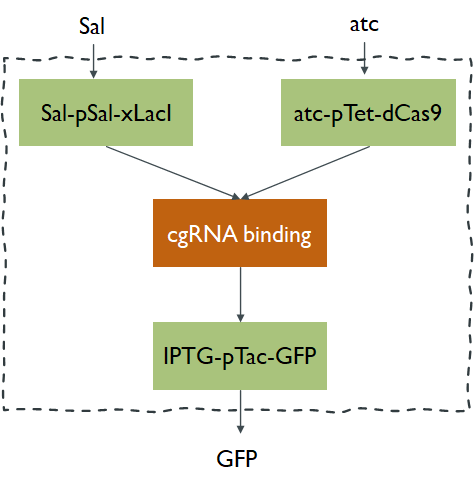

### Contracts for IPTG sensor

In [ ]:
yleak_iptg = df.loc[df["Inducer"] == "IPTG"]["ymin (RPUx10-3)"].values[0]*1e-3
iptg_start = 2
iptg_K = df.loc[df["Inducer"] == "IPTG"]["K (µM)"].values[0]
iptg_slope = 0.01
iptg_intercept = 0.0195
ymax_iptg = iptg_K*iptg_slope + iptg_intercept
contract_iptg0 = {
        "_comment": "",
        "InputVars":[
            "IPTG"
        ],
        "OutputVars":[
            "RPU"
        ],
        "assumptions":
        [
            {"coefficients":{"IPTG":1},
            "constant":iptg_start}
        ],
        "guarantees":[
            {"coefficients":{"RPU":-1},
            "constant":-yleak_iptg},
            {"coefficients":{"RPU":1},
            "constant":yleak_iptg}
        ]
    }
contract_iptg_lin = {
        "_comment": "",
        "InputVars":[
            "IPTG"
        ],
        "OutputVars":[
            "RPU"
        ],
        "assumptions":
        [
            {"coefficients":{"IPTG":1},
            "constant":iptg_K},
            {"coefficients":{"IPTG":-1},
            "constant":-iptg_start}
        ],
        "guarantees":[
            {"coefficients":{"RPU":-1, "IPTG":iptg_slope},
            "constant":iptg_intercept}, # make sure that there is wiggle room?
            {"coefficients":{"RPU":1, "IPTG":-iptg_slope},
            "constant":-iptg_intercept}
        ]
    }
contract_iptg_max = {
        "_comment": "",
        "InputVars":[
            "IPTG"
        ],
        "OutputVars":[
            "RPU"
        ],
        "assumptions":
        [
            {"coefficients":{"IPTG":-1},
            "constant":-iptg_K}
        ],
        "guarantees":[
            {"coefficients":{"RPU":1},
            "constant":ymax_iptg}
        ]
    }

Full circuit

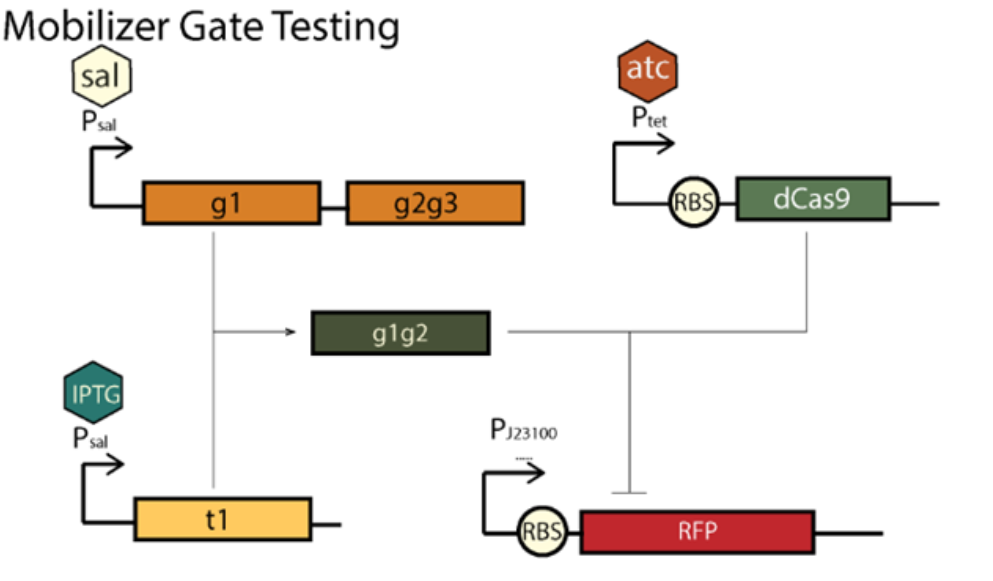